In [2]:
import utils.data_loader as data_loader  # new
import utils.models as models  # new
import utils.losses as losses # new
import utils.traintest as traintest #new

import pandas as pd
import numpy as np
import torch.nn as nn
import datetime
import time

/Users/axelgk/miniconda3/envs/cs330/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# some training start date
cutoff = datetime.datetime.strptime('2004-01-01', '%Y-%m-%d')

# load and modify data
# sample data (with some random noise overlay)
pd_X = pd.read_csv('https://www.dropbox.com/scl/fi/7moh3dehhxxm3qp0x05c4/sample_data_X.csv?rlkey=8f7su6vcj9c22gqui5oj13wdm&dl=1',index_col='DATE' )
pd_y = pd.read_csv('https://www.dropbox.com/scl/fi/4jjzh0zhz9jo950w7h250/sample_data_y.csv?rlkey=y9v5ntkdbvunn04g8t43h62yi&dl=1',index_col='DATE' )
pd_X.index = pd.to_datetime(pd_X.index,format='%Y-%m-%d')
for c in pd_X.columns:
    pd_X[c] = pd_X[c].astype(np.float32)
pd_y.index = pd.to_datetime(pd_y.index,format='%Y-%m-%d')
X_names_in = pd_X.columns
Y_names_in = pd_y.columns

In [3]:
# data loaders / train test split
train_loader, test_loader, train_data, test_data = data_loader.load_sent_data( train_batch_size = 50,
                                                        test_batch_size = 1000,
                                                        df = pd_X.join(pd_y), df_cutoff = cutoff,
                                                        Y_names=Y_names_in, Y_name_types={y:int for y in Y_names_in }, # int},
                                                        X_names=X_names_in,
                                                        train_dates=pd.date_range(start=cutoff, end="2018-06-30"),
                                                        convert_Y_to_labels = True, shuffle = True )


/Users/axelgk/miniconda3/envs/cs330/lib/python3.7/site-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/Users/axelgk/miniconda3/envs/cs330/lib/python3.7/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/axelgk/Documents/newsrepresentations/data_loader.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

Training on 5294 examples
Testing on 1280 examples


/Users/axelgk/Documents/newsrepresentations/data_loader.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k] = (df[k]>0)*1
/Users/axelgk/miniconda3/envs/cs330/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/Users/axelgk/Documents/newsrepresentations/data_loader.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [4]:
# set up model
saemodel = models.encoder_decoder( X_dim_in=len(X_names_in), map_layer_dims=[10], encoding_layer_dim=len(Y_names_in),
                                   dropout_p=0.1, classification=True,  external_enc = None,
                                   activations={'initial': nn.Tanh(), 'H': nn.Tanh(), 'loss': nn.Sigmoid(), 'final': nn.Identity()})


In [5]:
# set up train / test
sae = traintest.sae(model_in = saemodel,loss_fct_in = losses.loss_fixedW,
                   #sub_losses_in = [nn.MSELoss()]+ [nn.CrossEntropyLoss()]*len(Y_names_in), train_loss_wgt=False,
                   sub_losses_in=[nn.MSELoss()] + [nn.BCELoss()] * len(Y_names_in), train_loss_wgt=False,
                   lr_in= 0.005,
                   sub_losses_in_wgt_init = [10 / len(Y_names_in)] + [0.05 / len(Y_names_in)] * (len(Y_names_in) ),
                   classification=True, firsttrain_reconstruction=10,  l2strength = 0.00001,
                   sparse_regularizer= 0.0)

In [15]:
# start time
start_time = time.time()

# train
sae.train(epochs=40, train_loader = train_loader, val_loader = None)

# end time
end_time = time.time()


SAE train: Batch Nr 105  iteration
SAE train: Epoch:  0  - train_loss:  0.022992579177731558
SAE train: Epoch:  0  - train_accuracies  (if classif.):  [0.6060952380952375, 0.6678095238095234, 0.5251428571428568, 0.6699047619047617, 0.7786666666666677]
SAE train: Epoch: 0 - loss_0:0.022992579177731558.  - loss_1:0.0.  - loss_2:0.0.  - loss_3:0.0.  - loss_4:0.0.  - loss_5:0.0
SAE train: Epoch:  0  - loss weights:  [tensor(2.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)]
SAE train: Batch Nr 210  iteration
SAE train: Epoch:  1  - train_loss:  0.02267212065912428
SAE train: Epoch:  1  - train_accuracies  (if classif.):  [0.559238095238095, 0.5927619047619044, 0.516190476190476, 0.6295238095238094, 0.7036190476190479]
SAE train: Epoch: 1 - loss_0:0.02267212065912428.  - loss_1:0.0.  - loss_2:0.0.  - loss_3:0.0.  - loss_4:0.0.  - loss_5:0.0
SAE train: Epoch:  1  - loss weights:  [tensor(2.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)]
SAE train: Batch Nr 315  i

SAE train: Batch Nr 1785  iteration
SAE train: Epoch:  16  - train_loss:  0.052976188773200636
SAE train: Epoch:  16  - train_accuracies  (if classif.):  [0.6304761904761902, 0.6799999999999999, 0.5428571428571425, 0.6893333333333331, 0.7992380952380963]
SAE train: Epoch: 16 - loss_0:0.02318696787669545.  - loss_1:0.006445799497444005.  - loss_2:0.006011789052614144.  - loss_3:0.006856944354339723.  - loss_4:0.005934499323900257.  - loss_5:0.0045401883267221005
SAE train: Epoch:  16  - loss weights:  [tensor(2.), tensor(0.0100), tensor(0.0100), tensor(0.0100), tensor(0.0100), tensor(0.0100)]
SAE train: Batch Nr 1890  iteration
SAE train: Epoch:  17  - train_loss:  0.05284805989691192
SAE train: Epoch:  17  - train_accuracies  (if classif.):  [0.6314285714285713, 0.6860952380952381, 0.5451428571428568, 0.6908571428571432, 0.8015238095238105]
SAE train: Epoch: 17 - loss_0:0.02319883897545792.  - loss_1:0.006371082010723298.  - loss_2:0.005975459369697742.  - loss_3:0.006853817425490844. 

SAE train: Batch Nr 3255  iteration
SAE train: Epoch:  30  - train_loss:  0.05239136488664718
SAE train: Epoch:  30  - train_accuracies  (if classif.):  [0.6502857142857144, 0.6967619047619048, 0.5573333333333328, 0.6929523809523815, 0.8089523809523819]
SAE train: Epoch: 30 - loss_0:0.02326932937971183.  - loss_1:0.0062345439834254135.  - loss_2:0.005850006750829163.  - loss_3:0.006827233603135458.  - loss_4:0.005839112121611834.  - loss_5:0.004371138930409438
SAE train: Epoch:  30  - loss weights:  [tensor(2.), tensor(0.0100), tensor(0.0100), tensor(0.0100), tensor(0.0100), tensor(0.0100)]
SAE train: Batch Nr 3360  iteration
SAE train: Epoch:  31  - train_loss:  0.05241627845735778
SAE train: Epoch:  31  - train_accuracies  (if classif.):  [0.6521904761904763, 0.6939047619047621, 0.5550476190476187, 0.6866666666666673, 0.8049523809523819]
SAE train: Epoch: 31 - loss_0:0.02324332804197356.  - loss_1:0.006253971288069374.  - loss_2:0.0058260761068335614.  - loss_3:0.006828390194901398. 

In [16]:
print(f"Time: {end_time - start_time} s")

Time: 19.219771146774292 s


In [7]:
# get representations on test
pd_H = sae.predict_H(X_in=test_data.Xs, pd_index=test_data.pdidx, colnames_list = ['Eq', 'FI', 'Macr', 'Cmdty', 'FX'])
print(pd_H)

                  Eq        FI      Macr     Cmdty        FX
DATE                                                        
2018-07-01 -0.436846  0.014430  0.650088 -0.551866  0.775742
2018-07-02  0.148643  0.437071  0.567965 -0.170041 -0.383490
2018-07-03 -0.314505 -0.750408  0.430033  0.072312 -0.842200
2018-07-04 -0.097890  0.338290  0.467940 -0.085478 -0.652567
2018-07-05 -0.135742  0.054292  0.673494 -0.327591 -0.169226
...              ...       ...       ...       ...       ...
2021-12-27 -0.251514 -0.494861  0.426055  0.080689  0.691553
2021-12-28 -0.236154 -0.339490  0.635015 -0.435059  0.689296
2021-12-29 -0.224916 -0.697742  0.336666  0.236581  0.573699
2021-12-30  0.111962 -0.194212  0.542823  0.337454  0.655098
2021-12-31 -0.212821 -0.453827  0.504301 -0.145817  0.457889

[1280 rows x 5 columns]


<AxesSubplot:xlabel='DATE'>

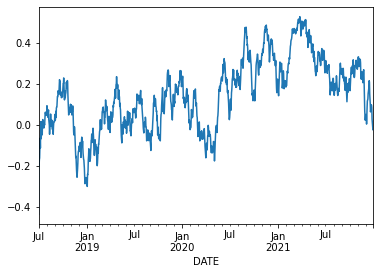

In [11]:
# plot the test representation
pd_H.Eq.ewm(halflife=10).mean().plot()